# Function defintions

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch.nn.init as init
import seaborn as sns

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Seaborn theme and font scaling for better aesthetics
sns.set(font_scale=1.2)
sns.set_style("whitegrid", {
    "grid.linestyle": ":", 
    "border.color": "black",
    "axes.edgecolor": "black",
    "xtick.bottom": "True",
    "xtick.top": "True",
    "ytick.left": "True",
    "ytick.right": "True",
    "xtick.direction": "in",
    "ytick.direction": "in"
})



# Define the MLP class
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, normalization_type):
        super(MLP, self).__init__()

        self.input_layer = nn.Linear(input_size, hidden_sizes[0],bias=False)
        self.hidden_layers = nn.ModuleList()
        self.normalization_layers = nn.ModuleList()
        self.normalization_type = normalization_type

        for i in range(1, len(hidden_sizes)):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i],bias=False))

            if normalization_type == "batch_norm":
                self.normalization_layers.append(nn.BatchNorm1d(hidden_sizes[i]))
            elif normalization_type == "layer_norm":
                self.normalization_layers.append(nn.LayerNorm(hidden_sizes[i]))

        self.output_layer = nn.Linear(hidden_sizes[-1], num_classes,bias=False)
        
        # Xavier initialization for linear layers
        for m in self.modules():
            if isinstance(m, nn.Linear):
                gain = nn.init.calculate_gain('relu')  # Custom gain value
                init.xavier_normal_(m.weight,gain=gain)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.input_layer(x)
        x = nn.functional.relu(x)

        hidden_representations = []
        for i in range(len(self.hidden_layers)):
            x = self.hidden_layers[i](x)

            if self.normalization_type is not None:
                x = self.normalization_layers[i](x)

            x = nn.functional.relu(x)
            hidden_representations.append(x)

        x = self.output_layer(x)

        return x, hidden_representations

def get_data_loaders(dataset_name, batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize inputs
    ])

    if dataset_name == "CIFAR10":
        train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                     download=True, transform=transform)
        test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                                    download=True, transform=transform)

    elif dataset_name == "CIFAR100":
        train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                                     download=True, transform=transform)
        test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                                    download=True, transform=transform)
    elif dataset_name == "MNIST":
        train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                                   download=True, transform=transform)
        test_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                                  download=True, transform=transform)
    else:
        raise ValueError("Invalid dataset name")

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                               shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)

    return train_loader, test_loader


def compute_gram_matrix_eigenvalues(hidden_representations):
    gram_matrices = []
    for representations in hidden_representations:
        gram_matrix = representations @  representations.t()
        eigenvalues = torch.linalg.eigvalsh(gram_matrix)
        eigenvalues = eigenvalues.cpu().detach().numpy()
        eigenvalues = np.array(tuple(eigenvalues))
        gram_matrices.append(eigenvalues)

    return gram_matrices

    
def train(model, train_loader, criterion, optimizer, device, epoch, experiment, df):
    model.train()
    loss_list = []

    progress_bar = tqdm(train_loader, desc="Train Epoch {}".format(epoch+1), leave=False)
    for i, (images, labels) in enumerate(progress_bar):
        images = images.to(device)
        labels = labels.to(device)

        outputs, hidden_layers = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_list.append(loss.item())

        if (i) % 10 == 0:
            loss_mean = sum(loss_list) / len(loss_list)
            for l,hidden_layer in enumerate(hidden_layers):
                G = hidden_layer @ hidden_layer.t()
                eigens = torch.linalg.eigvalsh(G).cpu().detach().numpy() 
                df = pd.concat([df, pd.DataFrame({
                    "Experiment": experiment, "Epoch": epoch, "Step": i, "Stage": "Training", 
                    "Loss": loss_mean, "Layer":l, "GramEigenvalues": [eigens]}, index=[0])], ignore_index=True)
            loss_list = []

            # Update progress bar description
            progress_bar.set_postfix({"Loss": loss_mean})

    return df

def test(model, test_loader, criterion, device, epoch, experiment, df):
    with torch.no_grad():
        correct = 0
        total = 0
        loss_list = []

        progress_bar = tqdm(test_loader, desc="Test Epoch {}".format(epoch+1), leave=False)
        for i, (images, labels) in enumerate(progress_bar):
            images = images.to(device)
            labels = labels.to(device)
            outputs, hidden_layers = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss = criterion(outputs, labels)
            loss_list.append(loss.item())
            
            if (i) % 10 == 0:
                loss_mean = sum(loss_list) / len(loss_list)
                for l,hidden_layer in enumerate(hidden_layers):
                    G = hidden_layer @ hidden_layer.t()
                    eigens = torch.linalg.eigvalsh(G).cpu().detach().numpy()
                    df = pd.concat([df, pd.DataFrame({
                        "Experiment": experiment, 
                        "Epoch": epoch, "Step": i, "Stage": "Test", 
                        "G": [G.cpu().detach().numpy()],
                        "labels": [labels.cpu().detach().numpy()], 
                        "predicted": [predicted.cpu().detach().numpy()], 
                        "outputs": [outputs.cpu().detach().numpy()],
                        "Loss": loss_mean, "Layer":l, "GramEigenvalues": [eigens]}, index=[0])], ignore_index=True)
                loss_list = []
    
                # Update progress bar description
                progress_bar.set_postfix({"Loss": loss_mean})

        accuracy = 100 * correct / total
        loss_mean = sum(loss_list) / len(loss_list)

        df = pd.concat([df, pd.DataFrame({"Experiment": experiment, "Epoch": epoch+1, "Step": i, "Stage": "Test", "Loss": loss_mean, "Accuracy": accuracy}, index=[0])], ignore_index=True)

    return df

def train_and_test(model, train_loader, test_loader, criterion, optimizer, device, config, experiment):
    # Create a DataFrame to store the results
    columns = ["Experiment", "Epoch", "Step", "Stage", "Loss", "Accuracy", "Layer", "GramEigenvalues"]
    results_df = pd.DataFrame(columns=columns)

    # Training and testing
    for epoch in range(config["num_epochs"]):
        if epoch>0:
            results_df = train(model, train_loader, criterion, optimizer, device, epoch, experiment, results_df)
        results_df = test(model, test_loader, criterion, device, epoch, experiment, results_df)

    return results_df


def run_experiment(experiment_configs):
    configs_df = pd.DataFrame(experiment_configs)
    # Create a DataFrame to store the results of all experiments
    columns = ["Experiment", "Epoch", "Step", "Stage", "Loss", "Accuracy"]
    results_df = pd.DataFrame(columns=columns)
    for config in experiment_configs:
        # print the config 
        print(config )
        # Get the data loaders
        train_loader, test_loader = get_data_loaders(config["dataset_name"], config["batch_size"])
    
        # Create the MLP model with the specified normalization type
        model = MLP(input_size=config["input_size"], hidden_sizes=config["hidden_sizes"], 
                    num_classes=config["num_classes"], normalization_type=config["normalization_type"]).to(device)
        # Loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=config["learning_rate"])
    
        # Train and test
        experiment_df = train_and_test(model, train_loader, test_loader, criterion, optimizer, device, config, config["experiment"])
    
        # Append the experiment results to the overall results DataFrame
        results_df = pd.concat([results_df, experiment_df])
    
    # Print the results DataFrame
    configs_df = pd.DataFrame(experiment_configs)
    df = pd.merge(results_df, configs_df, left_on='Experiment',right_on='experiment')
    return df

# Tracking  Gram matrix during training 
In the following experiment, we track the evolution of the Gram matrix during training. We consider a L-layer MLP with ReLU activation, both with and without batch normalization. We train the network on CIFAR100 with SGD and we track the evolution of the Gram matrix of the last hidden layer during training. 


In [1]:

    
# Configuration parameters for multiple experiments
experiment_configs = [
    {
        "experiment": 1,
        "dataset_name": "CIFAR100",
        "input_size": 32 * 32 * 3,
        "hidden_sizes": [1000] * 10,
        "num_classes": 100,
        "batch_size": 128,
        "learning_rate": 0.001,
        "num_epochs": 50,
        "normalization_type": None
    },
    {
        "experiment": 2,
        "dataset_name": "CIFAR100",
        "input_size": 32 * 32 * 3,
        "hidden_sizes": [1000] * 10,
        "num_classes": 100,
        "batch_size": 128,
        "learning_rate": 0.001,
        "num_epochs": 50,
        "normalization_type": "batch_norm"
    }
]


df = run_experiment(experiment_configs)


{'experiment': 1, 'dataset_name': 'CIFAR100', 'input_size': 3072, 'hidden_sizes': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000], 'num_classes': 100, 'batch_size': 128, 'learning_rate': 0.001, 'num_epochs': 50, 'normalization_type': None}
Files already downloaded and verified
Files already downloaded and verified


{'experiment': 2, 'dataset_name': 'CIFAR100', 'input_size': 3072, 'hidden_sizes': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000], 'num_classes': 100, 'batch_size': 128, 'learning_rate': 0.001, 'num_epochs': 50, 'normalization_type': 'batch_norm'}
Files already downloaded and verified
Files already downloaded and verified


# Gram matrix during training with(out) batch normalization
In the followign we observe that the Gram matrix with batch normalization converges to the Gram matrix of the infinite width network, i.e., mean-field estimate, while the Gram matrix without batch normalization does not converge to the Gram matrix of the infinite width network.

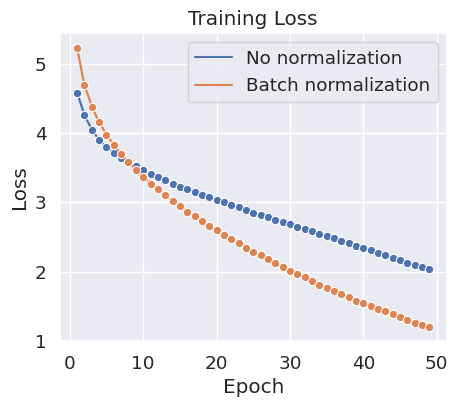

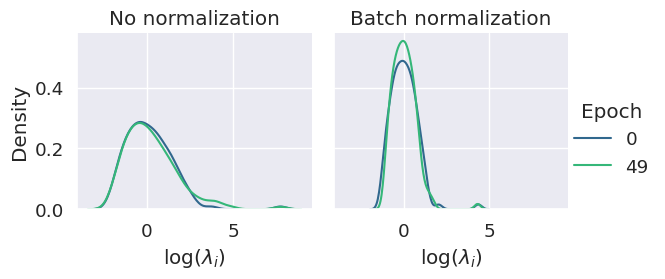

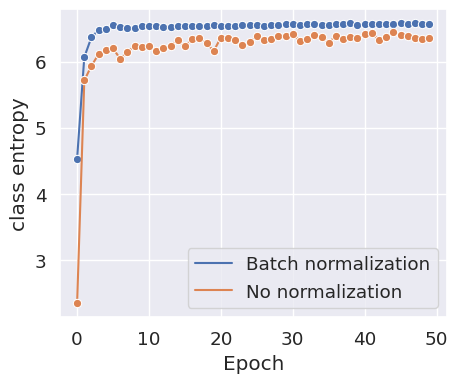

In [2]:


from matplotlib import pyplot as plt


def entropy(x):
    x = x[x>0]
    return -np.sum(np.log2(x)*x)

# Seaborn theme and font scaling for better aesthetics
sns.set_theme(style="whitegrid")
sns.set(font_scale=1.2)

df.loc[df.normalization_type.isna(),'normalization_type'] = 'No normalization'
df.loc[df.normalization_type=='batch_norm','normalization_type'] = 'Batch normalization'

# Plot loss curve
plt.figure(figsize=(5, 4))
sns.lineplot(data=df.loc[df.Stage=='Training'], x='Epoch', y='Loss', hue='normalization_type',marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend(title='')
plt.savefig('icml_plots/loss_plot.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Plot density of eigenvalues of penultimate Gram 
eigenvalue_df = df
eigenvalue_df['GramEigenvalues'] = eigenvalue_df.GramEigenvalues.apply(lambda x: x/np.median(x))
eigenvalue_df = eigenvalue_df.explode("GramEigenvalues", ignore_index=True)
eigenvalue_df = eigenvalue_df.loc[eigenvalue_df.Layer == eigenvalue_df.Layer.max() ]
eigenvalue_df = eigenvalue_df.loc[eigenvalue_df.Epoch.isin([0,49]) ]
eigenvalue_df['GramEigenvalues_log'] = eigenvalue_df.GramEigenvalues.apply(lambda x: np.log(x))


g = sns.FacetGrid(data=eigenvalue_df.loc[eigenvalue_df.Stage=='Test'],col="normalization_type", hue="Epoch", palette="viridis", height=3, aspect=1)
g.map(sns.kdeplot, "GramEigenvalues_log",)
# g.map(sns.histplot, "GramEigenvalues_log", stat='density',alpha=.7)
g.set_axis_labels("$\log(\lambda_i)$", "Density")  # Set x-label and y-label
g.set_titles("{col_name}")  # Set title based on the column name
g.add_legend(title='Epoch')
plt.savefig('icml_plots/gram_eigenvalues_plot.pdf', format='pdf', bbox_inches='tight')
plt.show()

n = int(df.num_classes.iloc[0])
plt.figure(figsize=(5, 4))
stats = df.loc[~df.predicted.isna()].explode('predicted').groupby(
    ['Epoch','normalization_type'])['predicted'].agg(lambda x: np.histogram(x,bins=range(1+n),density=True)[0]).reset_index()
stats.loc[:,'entropy'] = stats.apply(lambda x: entropy(x.predicted),axis=1)
sns.lineplot(stats, x='Epoch',y='entropy',hue='normalization_type',marker='o')
# plt.plot(range(50), np.ones(50)*np.log2(100),'--',color='k',label='theory')
plt.ylabel('class entropy')
plt.legend(title='')
plt.savefig('icml_plots/class_entropy.pdf', format='pdf', bbox_inches='tight')

plt.show()